# Make...
- loads an output pkl file processed by the `trigger_efficiencies_processor.py` June 25th iteration which does not apply the dxy, dz requirements on the Muons but saves them as booleans `muon_dxy`, `muon_dz`
- checks the effect of the dxy, dz requirements on the trigger efficiency plots

In [1]:
import glob
import json
import os
import pickle
import pickle as pkl

import hist as hist2
import matplotlib.pyplot as plt
import mplhep as hep
import numpy as np
import pandas as pd
import pyarrow.parquet as pq
import yaml
from hist.intervals import clopper_pearson_interval
from scipy.special import softmax
from sklearn.metrics import auc, roc_curve

import matplotlib.pyplot as plt

import sys
sys.path
sys.path.append("../python/")
import utils
from make_stacked_hists import make_events_dict

pd.options.mode.chained_assignment = None

plt.rcParams.update({"font.size": 20})
plt.style.use(hep.style.CMS)

In [3]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
outdir = f"/Users/fmokhtar/Desktop/AN_2024/HWW_lepton_fraction/"

if not os.path.exists(outdir):
    os.makedirs(outdir)

In [63]:
 # define your regions here
presel = {
        "mu": {
            "msoftdrop": "fj_mass>40",
        },
        "ele": {
            "msoftdrop": "fj_mass>40",
        },
}

years = ["2017", "2016", "2016APV", "2018"]
channels = ["ele", "mu"]

samples = [
    "ggF", 
    "VBF",  
    "WH",
    "ZH",    
    "ttH",
]

samples_dir = {
    "2016":    "../eos/May31_hww_2016",
    "2016APV": "../eos/May31_hww_2016APV",
    "2017":    "../eos/May31_hww_2017",
    "2018":    "../eos/May31_hww_2018",
}

events_dict = {}
for year in years:
    
    out = make_events_dict([year], channels, samples_dir[year], samples, presel)
    events_dict = {**events_dict, **out}

INFO:root:Finding VBFHToWWToAny_M-125_TuneCP5_withDipoleRecoil samples and should combine them under VBF
INFO:root:Applying msoftdrop selection on 1745 events
INFO:root:Will fill the VBF dataframe with the remaining 1481 events
INFO:root:tot event weight 12.413656103948622 

INFO:root:Finding HWminusJ_HToWW_M-125 samples and should combine them under WH
INFO:root:Applying msoftdrop selection on 4084 events
INFO:root:Will fill the WH dataframe with the remaining 3431 events
INFO:root:tot event weight 2.426111906111235 

INFO:root:Finding GluGluHToWW_Pt-200ToInf_M-125 samples and should combine them under ggF
INFO:root:Applying msoftdrop selection on 4951 events
INFO:root:Will fill the ggF dataframe with the remaining 4253 events
INFO:root:tot event weight 35.44621675087096 

INFO:root:Finding HWplusJ_HToWW_M-125 samples and should combine them under WH
INFO:root:Applying msoftdrop selection on 4843 events
INFO:root:Will fill the WH dataframe with the remaining 4094 events
INFO:root:tot 

INFO:root:tot event weight 1.8793883569428007 

INFO:root:Finding ttHToNonbb_M125 samples and should combine them under ttH
INFO:root:Applying msoftdrop selection on 5370 events
INFO:root:Will fill the ttH dataframe with the remaining 5056 events
INFO:root:tot event weight 9.471502017044715 

INFO:root:Finding GluGluZH_HToWW_M-125_TuneCP5_13TeV-powheg-pythia8 samples and should combine them under ZH
INFO:root:Applying msoftdrop selection on 5480 events
INFO:root:Will fill the ZH dataframe with the remaining 4734 events
INFO:root:tot event weight 0.050458870829838284 

INFO:root:Finding HZJ_HToWW_M-125 samples and should combine them under ZH
INFO:root:Applying msoftdrop selection on 4220 events
INFO:root:Will fill the ZH dataframe with the remaining 3604 events
INFO:root:tot event weight 1.5921769770528713 

INFO:root:Finding VBFHToWWToAny_M-125_TuneCP5_withDipoleRecoil samples and should combine them under VBF
INFO:root:Applying msoftdrop selection on 860 events
INFO:root:Will fill th

In [64]:
# combine all dataframes
df = None
for year in years:
    for ch in channels:
        for sample in samples:
            if df is None:
                df = events_dict[year][ch][sample]
            else:
                df = pd.concat(
                    [
                        df,
                        events_dict[year][ch][sample],
                    ]
                )        

In [65]:
df

,fj_lsf3,fj_VScore,lep_pt,lep_eta,lep_isolation,lep_misolation,lep_fj_dr,lep_met_mt,met_fj_dphi,met_pt,...,rec_higgs_mJES_HF_2018_down,rec_higgs_ptJES_HF_2018_down,rec_higgs_mJES_Absolute_2018_up,rec_higgs_ptJES_Absolute_2018_up,rec_higgs_mJES_Absolute_2018_down,rec_higgs_ptJES_Absolute_2018_down,weight_btagSFlight2018Up,weight_btagSFlight2018Down,weight_btagSFbc2018Up,weight_btagSFbc2018Down
0,0.820312,0.955659,137.119827,1.086670,0.160244,0.019522,0.202446,32.348125,0.364338,64.195007,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.814453,0.171414,74.474464,-1.732178,0.000000,0.000000,0.581091,7.796468,-0.429772,26.747561,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.993164,0.588955,98.738327,0.821533,0.000000,0.000000,0.300742,22.726410,0.139960,39.016441,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.980957,0.655037,109.961838,0.021481,0.013014,0.007645,0.218484,54.135853,-0.778666,79.347450,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,0.991211,0.436070,79.914490,1.606689,0.008898,0.000000,0.343460,44.054588,-0.392888,56.699089,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5716,0.735352,0.586667,59.468842,-1.046631,0.220414,0.031986,0.173375,49.519611,0.694128,126.956566,...,191.807819,396.533325,191.524921,396.713348,191.840022,395.885834,0.998522,1.000359,1.000000,1.000000
5717,0.269287,0.859343,58.777157,-0.103043,0.480078,0.161284,0.398112,48.653904,0.270190,134.110306,...,127.368565,394.717651,127.201881,394.921600,127.536040,394.514648,0.999361,1.000061,1.110882,1.152064
5718,0.200684,0.569144,111.862564,-1.215576,0.007680,0.000000,0.462679,23.905109,-0.628604,86.692055,...,218.040289,418.030426,218.064991,419.158875,218.016328,416.902832,0.999448,1.000129,0.986832,1.425832
5719,0.971191,0.942098,153.411942,-0.505493,0.023431,0.000000,0.193629,10.313213,0.258106,131.745941,...,97.945594,516.167725,97.775299,516.356018,97.983241,515.303162,0.998642,1.000426,0.965979,1.544633


In [72]:
df["THWW"]

0       0.128484
1       0.002289
2       0.924474
4       0.033329
6       0.567760
          ...   
5716    0.672515
5717    0.035585
5718    0.109857
5719    0.008171
5720    0.100747
Name: THWW, Length: 273138, dtype: float32

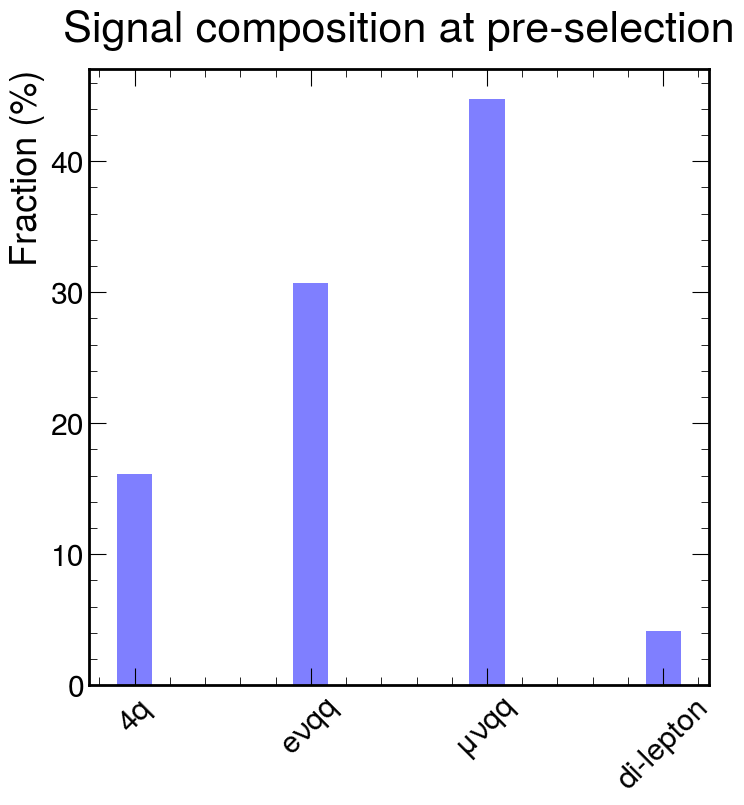

In [85]:
fig, ax = plt.subplots(figsize=(8, 8))    

den = df["event_weight"][(df["fj_lepinprongs"] <= 2)].sum()

# Define the data
ngenleptons = ["4q", r"$e \nu qq$", r"$\mu \nu qq$", "di-lepton"]
counts = [
    df["event_weight"][(df["fj_lepinprongs"] == 0)].sum() / den, 
    df["event_weight"][((df["fj_lepinprongs"] == 1) & (df["fj_H_VV_elenuqq"] == 1))].sum() / den,
    df["event_weight"][((df["fj_lepinprongs"] == 1) & (df["fj_H_VV_munuqq"] == 1))].sum() / den,
    df["event_weight"][(df["fj_lepinprongs"] == 2)].sum() / den,
]

counts = np.array(counts)
counts *= 100

# Create the bar plot
ax.bar(
    ngenleptons, 
    counts,
    width=0.2,
    color='blue', 
    alpha=0.5,

)

# Add labels and title
plt.ylabel('Fraction (%)')
plt.title('Signal composition at pre-selection', pad=20)
plt.xticks(ngenleptons, rotation=45)  # Ensure the x-axis labels match ngenleptons

# Show the plot
plt.show()

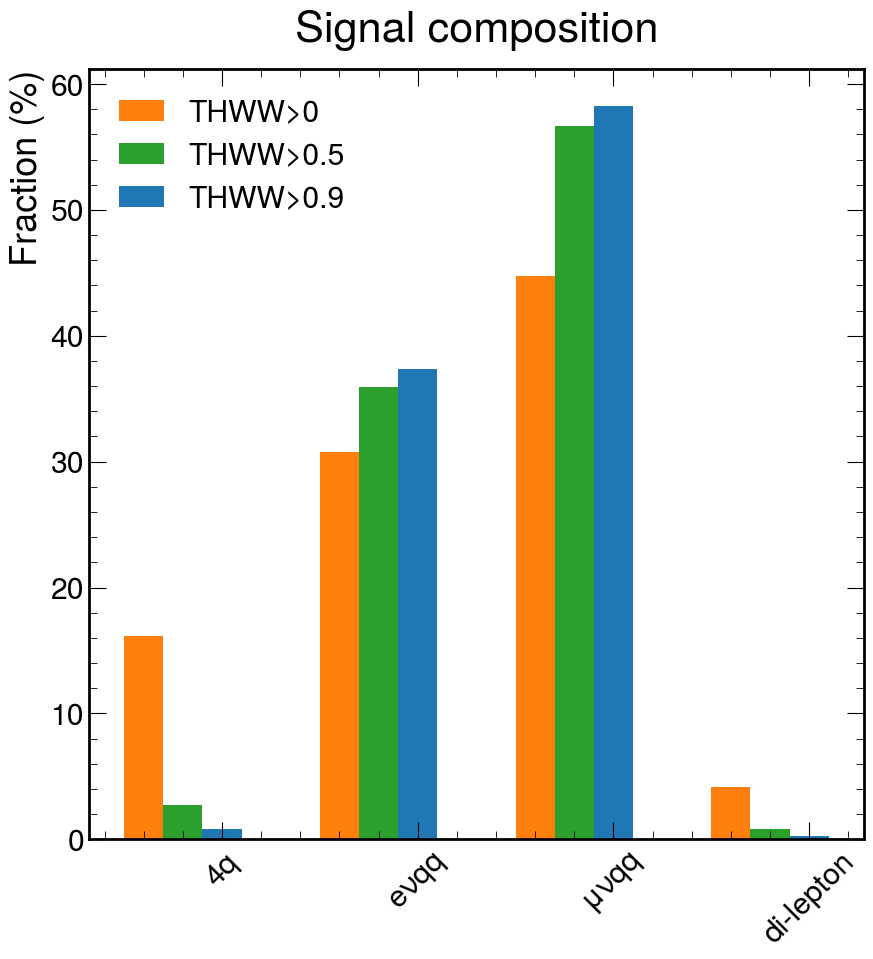

In [128]:
color_dict = {
    0: "tab:orange",
    0.5: "tab:green",
    0.9: "tab:blue",
}

fig, ax = plt.subplots(figsize=(10, 10))    

bar_width = 0.2

decay_channels = ["4q", r"$e \nu qq$", r"$\mu \nu qq$", "di-lepton"]
tagger_cuts = [0, 0.5, 0.9]

for idecay_channel, decay_channel in enumerate(decay_channels):
    for i, tagger_cut in enumerate(tagger_cuts):
    
        msk = df["THWW"] > tagger_cut
        den = df["event_weight"][msk & (df["fj_lepinprongs"] <= 2)].sum()

        # Define the data
        counts = [
            100 * df["event_weight"][msk & (df["fj_lepinprongs"] == 0)].sum() / den, 
            100 * df["event_weight"][msk & ((df["fj_lepinprongs"] == 1) & (df["fj_H_VV_elenuqq"] == 1))].sum() / den,
            100 * df["event_weight"][msk & ((df["fj_lepinprongs"] == 1) & (df["fj_H_VV_munuqq"] == 1))].sum() / den,
            100 * df["event_weight"][msk & (df["fj_lepinprongs"] == 2)].sum() / den,
        ]

        X = counts[idecay_channel]
        bars = ax.bar(idecay_channel + i * bar_width, X, bar_width, label=f"THWW>{tagger_cut}", color=color_dict[tagger_cut])

    # Add a legend
    handles, labels = ax.get_legend_handles_labels()[0][:len(tagger_cuts)], ax.get_legend_handles_labels()[1][:len(tagger_cuts)]
    plt.legend(handles, labels, loc='upper left', fancybox=True, shadow=True, framealpha=1, edgecolor='black')

plt.ylabel('Fraction (%)')

plt.xticks(np.arange(len(decay_channels)) + bar_width * 2, decay_channels, rotation=45)
plt.title('Signal composition', pad=20)

plt.savefig("/Users/fmokhtar/Desktop/AN_2024/sig_comp_tagger.pdf")